# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
# Se importan las librerías necesarias:
# import os
from bs4 import BeautifulSoup # Se utiliza para transformar el html de la página web y poder trabajar con él
import requests # Se utiliza para realizar la petición a la página web
#import time
import sqlite3 # Se utiliza para poder trabajar en SQL
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
# from sqlalchemy import create_engine


### Paso 1 - Instalación de dependencias:

Se ha de ejecutar el siguiente **comando** en la terminal del entorno de programación:

<p style = 'text-align: center';> <code >pip install pandas requests

### Paso 2 - Descarga del HTML:

En este caso, al no haber podido acceder a la web que se indicaba en el enunciado del ejercicio, se buscó otra en la que sí se tuviesen los permisos necesarios:

Enlace a Web empleado: https://companiesmarketcap.com/tesla/revenue/




In [2]:
# Se declara una variable para almacenar la URL:
url = 'https://companiesmarketcap.com/tesla/revenue/';

# Se realiza una petición a la URL guardada:
response = requests.get(url);

# Se evalúa el código devuelto de la petición
# Si se devuelve el código 200, se va a poder trabajar con la URL:
if response.status_code == 200:

    # Se guarda el código HTML utilizando la librería BeautifulSoup:
    soup = BeautifulSoup (response.content, 'html.parser'); # Se da el contenido obtenido en la respuesta a la petición y se indica que es 'HTML'

    # Tras una inspección al código fuente, se ha comprobado que la tabla a estudiar tiene la etiqueta <table> y se encuentra dentro de la clase 'table'
    table = soup.find_all ('table', class_ = 'table');

# Si no se devuelve el código 200, no se puede trabajar con la URL y se muestra qué código 
else: 
    print (f"La URL seleccionada no permite trabajar con ella. Se ha devuelto el siguiente código de respuesta: {response.status_code}");
 

Tras realizar la petición, se ha comprobado que el código de la respuesta permitía trabajar con la URL seleccionada. 

De esta forma, se ha traducido el HTML y, tras una inspección al código fuente para comprobar qué parte era la que interesaba, se han guardado en la variable 'table' todas las tablas cuya etiqueta fuese /table/ y estuviesen dentro de la clase 'table'. 

A continuación, solo se va a trabajar con la **primera de todas las tablas** con esas características para extraer los **años** y las **ganancias** obtenidos en esa tabla.

Como se va a querer trabajar con estos datos, es necesario, primero, obtenerlo y, segundo, tratarlos para quitar cualquier elemento que no sirva.

**Years:** Se ha comprobado que se encuentran dentro de las etiquetas /span/ con la clase 'year'

**Revenue:** Se ha comprobado que se encuentran dentro de las etiquetas /td/ pero, en este caso, se ha de filtrar de forma que solo se trabaje con el texto detectado que contenga '$'

In [6]:
# # # FUNCIÓN PARA LA EXTRACCIÓN DE LOS AÑOS # # #
# Se declara una función que recibe como variable del tipo BeautifulSoup y devuelve una lista de Integers con todos los años contenidos en la tabla:
def get_years (selected_table):
    
    # Se buscan todos los años según el criterio definido (etiqueta <span>, clase 'year), se extrae el contenido con get.text() y se pasa a entero para tratarlo como número:
    return [int(year.get_text()) for year in selected_table.find_all('span', class_ = 'year')];


# # # FUNCIÓN PARA LA EXTRACCIÓN DE LOS BENEFICIOS # # #
# Se declara una función que recibe como variable del tipo BeautifulSoup y devuelve una lista de float con todos los beneficios contenidos en la tabla:
def get_revenue (selected_table):

    # Se buscan todos los beneficios, encontrando todo lo que esté bajo la etiqueta <td> y tenga el character '$'
    # Además, solo interesa tener los números, por lo que, una vez se ha extraído el contenido, se reemplazan los símbolos de '$' y 'B' por '' (nada):
    return [float(revenue.get_text().replace('$', '').replace('B', '')) for revenue in selected_table.find_all ('td') if '$' in revenue.get_text()]


# Se guarda en una variable la primera de todas las tablas encontradas:
selected_table = table[0];

# Se llama a ambas funciones para poder guardar los años y beneficios:
years = get_years (selected_table);
revenues = get_revenue (selected_table);

# Se declara una lista vacía que contendrá, a su vez, la lista de los años y la lista de los valores de beneficio:
data = []

# Se itera por ambas listas para poder ir añadiendo los elementos a la lista vacía:
for year, revenue in zip(years, revenues):
    data.append ((year, revenue));

# Se pasa la lista a Data Frame, definiendo las columnas como 'Years' y 'Revenues':
df = pd.DataFrame (data, columns = ['Years', 'Revenues']);

# Se imprime el Data Frame:
print ('Data Frame: Años y Beneficios de Tesla');
df



Data Frame: Años y Beneficios de Tesla


,Years,Revenues
0,2024,97.15
1,2023,96.77
2,2022,81.46
3,2021,53.82
4,2020,31.53
5,2019,24.57
6,2018,21.46
7,2017,11.75
8,2016,7.00
9,2015,4.04


### Paso 4 - Almacenar datos en un SQLite:

Una vez se ha creado el DataFrame a partir de la información tomada de la URL se va a utilizar este DataFrame para obtener una tabla en una base de datos de SQLite

In [8]:
# Se conecta a la base de datos SQLite y, si no existe, se crea:
conexion = sqlite3.connect('revenue_data_base.db');

# Se crea un cursor para poder ejecutar consultas sobre la base de datos:
cursor = conexion.cursor();

# Se crea una tabla con el nombre 'revenues_table' con dos columnas para almacenar los años y beneficios, atendiendo al tipo de variable con la que están declarados en el DataFrame
get_table = """
CREATE TABLE if not exisits revenues_table (
    Year INT, 
    Revenue FLOAT 
);
"""

# Se pasa el contenio del DataFrame a la tabla de la base de datos establecida en la conexion:
df.to_sql('revenues_table', con = conexion, if_exists = 'replace', index = False);

# Se guardan los cambios en la base de datos:
conexion.commit()

# Se crea la consulta para tener seleccionados todos los elementos de la tabla con los datos:
consulta_revenues = """
SELECT * FROM revenues_table
"""

# Se guarda en el cursor la selección:
cursor.execute(consulta_revenues)

# Se recuperan todos los registros de la consulta (todos los elementos de la tabla)
registros = cursor.fetchall();

# Se muestran todos los datos de la tabla:
print ("Datos de la Tabla 'revenues_table'");
registros



Datos de la Tabla 'revenues_table'


[(2024, 97.15),
 (2023, 96.77),
 (2022, 81.46),
 (2021, 53.82),
 (2020, 31.53),
 (2019, 24.57),
 (2018, 21.46),
 (2017, 11.75),
 (2016, 7.0),
 (2015, 4.04),
 (2014, 3.19),
 (2013, 2.01),
 (2012, 0.41),
 (2011, 0.2),
 (2010, 0.11),
 (2009, 0.11)]

### Paso 5 - Visualizar los Datos:

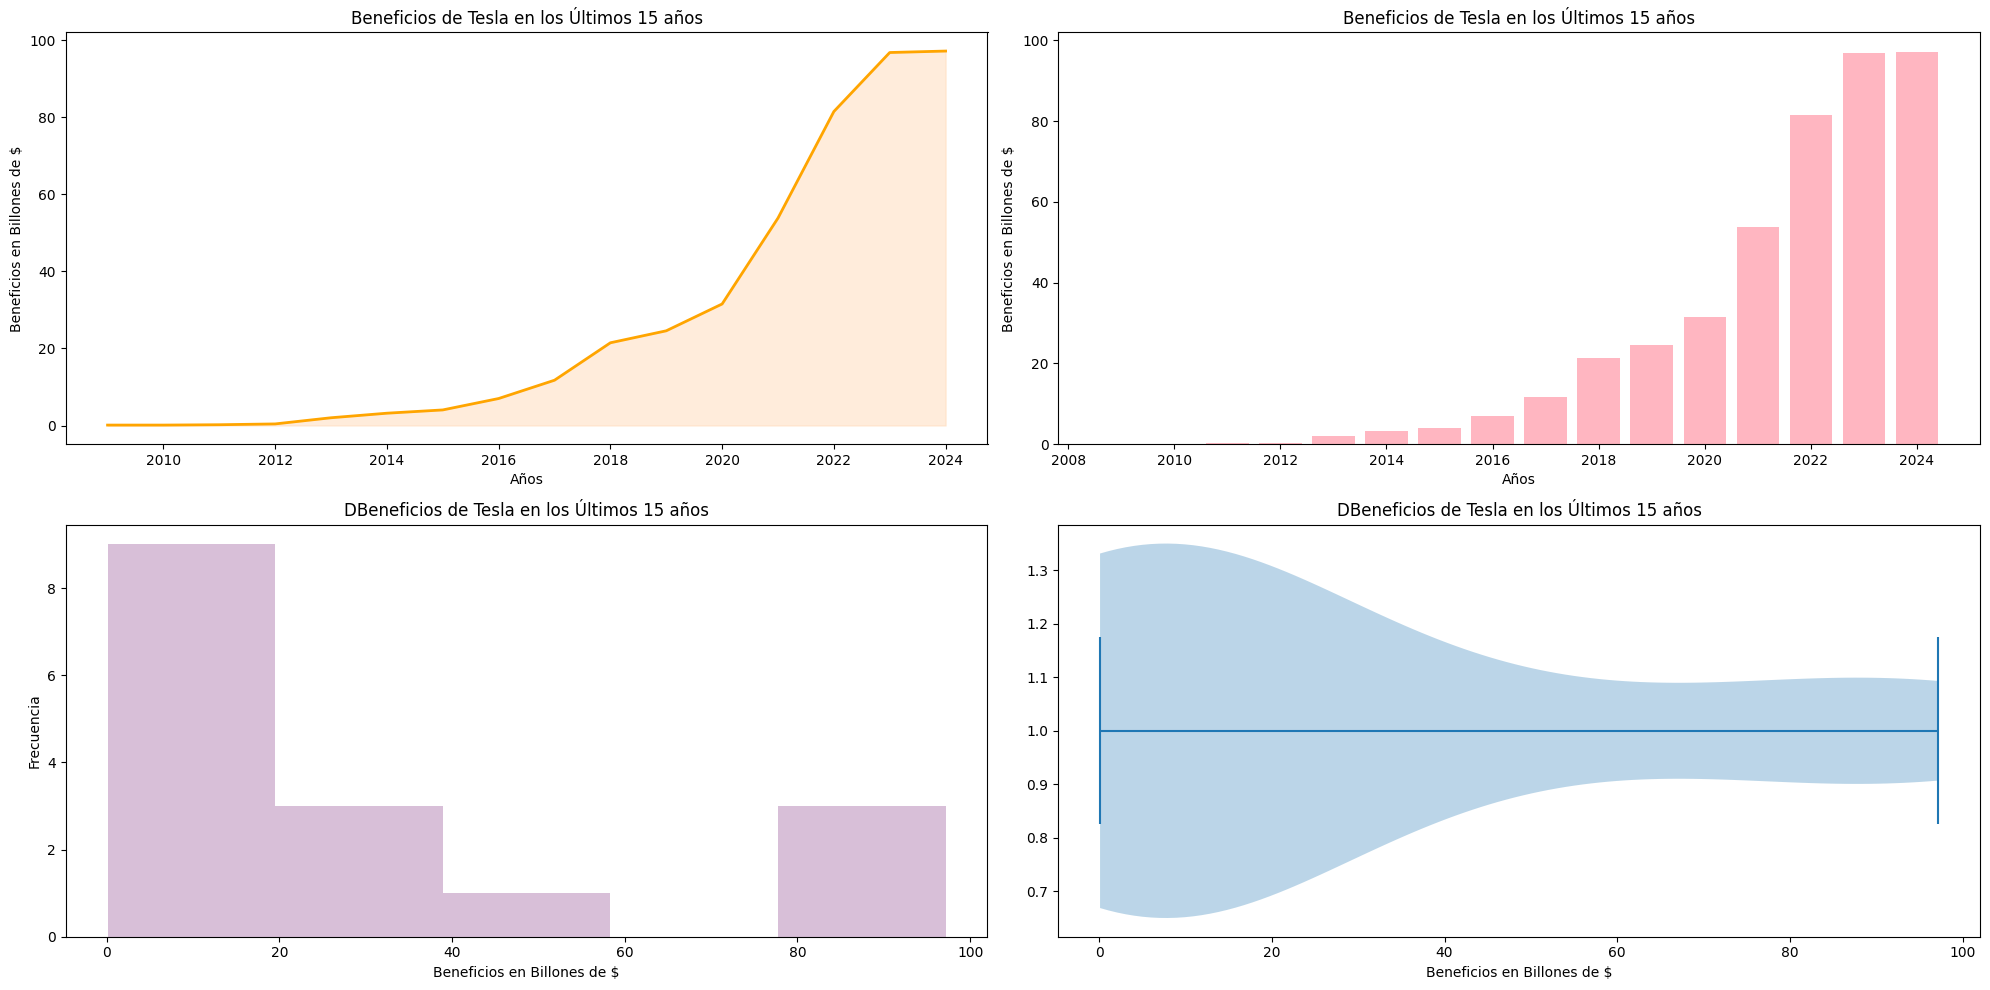

In [35]:
# Se crea la figura:
plt.figure(figsize = (20, 10));

# Gráfico de Línea Simple:
plt.subplot (2, 2, 1);
plt.fill_between(years, revenues, color="peachpuff", alpha=0.5, label="Beneficios")
plt.plot (years, revenues, color = 'orange', linewidth = 2);
plt.title ("Beneficios de Tesla en los Últimos 15 años");
plt.xlabel ("Años");
plt.ylabel ("Beneficios en Billones de $");


# Gráfico de Barras:
plt.subplot (2, 2, 2);
plt.bar(years, revenues, color = 'lightpink');
plt.title("Beneficios de Tesla en los Últimos 15 años");
plt.xlabel("Años");
plt.ylabel("Beneficios en Billones de $");


# Gráfico de tipo Histograma:
plt.subplot (2, 2, 3);
plt.hist(revenues, bins=5, color='thistle');
plt.title("DBeneficios de Tesla en los Últimos 15 años");
plt.xlabel("Beneficios en Billones de $");
plt.ylabel("Frecuencia");


# Gráfico de Violín:
plt.subplot (2, 2, 4);
plt.violinplot(revenues, vert=False, widths=0.7);
plt.title("DBeneficios de Tesla en los Últimos 15 años");
plt.xlabel("Beneficios en Billones de $");


plt.tight_layout();
plt.show();


En los gráficos mostrados arriba se pueden realizar dos análisis distintos pero complementarios: 

- Por un lado, gracias tanto al **gráfico de línea simple** como al **gráfico de barras**, se puede ver la **clara tendencia al alza de los benefios de Tesla** en los últimos 15 años. Esta tendencia partía de **beneficios muy por debajo de los 20 Billones de $ hasta prácticamente 2018**, pero con un **auge** de tendencia casi **exponencial** a partir de dicho año. Desde el 2023, los **beneficios han parecido estancarse**, teniendo un valor muy similar en el 2024.

- Además, atendiendo al **histograma** y al **gráfico de violín**, se puede observar que si se analizan los últimos 15 años de beneficios, el **rango con mayor frecuencia es el menor**. Esto tiene sentido ya que, como se ha visto en los gráficos superiores, **durante casi 9 años**, los **beneficios** de Tesla **no superaron los 20 Billones de $**. 